In [1]:
import torch
from torch import nn 
from torch.utils.data import Dataset,DataLoader,TensorDataset
import numpy
import pandas as pd
import os
import h5py
import re

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.getcwd()
print(os.getcwd())
path = "/content/drive/MyDrive/Colab Notebooks/droplanding_experiment_data/"
os.chdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/droplanding_experiment_data


## Data preprocess

In [2]:
import torch
import h5py
import numpy


def read_rawdata(row_idx: int,col_names: list)-> numpy.ndarray:
    """
    @Description:
    To read the data from h5 file and normalize the features and labels.
    @Parameters:
    Row_idx: the index of row. data type is int
    Col_names: the names of columns. data type is string
    
    """
    with h5py.File('raw_datasets.hdf5', 'r') as fd:
        ## The coloms of the features and labels
        keys=list(fd.keys())
        columns=fd[keys[0]].attrs.get('columns')
        col_idxs=[]
        for col_name in col_names:
            col_idxs.append(np.argwhere(columns==col_name)[0][0])
        
        data_len_list=[]
        for idx in range(len(fd.keys())):
            key="sub_"+str(idx)
            #print(key)
            data_len_list.append(len(fd[key]))
        
        data_len_list_sum=[]
        sum_num=0
        for num in data_len_list:
            sum_num+=num
            data_len_list_sum.append(sum_num)
        
        data_len_list_sum=np.array(data_len_list_sum)
        
        sub_idx=np.argwhere(data_len_list_sum > row_idx)[0,0]
        if(sub_idx>0):
            row_idx=row_idx-data_len_list_sum[sub_idx-1]
            
        return fd['sub_'+str(sub_idx)][row_idx,col_idxs]
    
    

def normalization_parameters(row_idx,col_names):
    with h5py.File('raw_datasets.hdf5', 'r') as fd:
        keys=list(fd.keys())# the keys/columns name of the datafile 
        columns=fd[keys[0]].attrs.get('columns')
        col_idxs=[]
        for col_name in col_names:
            col_idxs.append(np.argwhere(columns==col_name)[0][0])
    
        data_len_list=[]
        for idx in range(len(fd.keys())):
            key="sub_"+str(idx)
            data_len_list.append(len(fd[key]))
    
        data_len_list_sum=[]
        sum_num=0
        for num in data_len_list:
            sum_num+=num
            data_len_list_sum.append(sum_num)
    
        data_len_list_sum=np.array(data_len_list_sum)
    
        sub_idx=np.argwhere(data_len_list_sum > row_idx)[0,0]
        if(sub_idx>0):
            row_idx=row_idx-data_len_list_sum[sub_idx-1]
            sub_idx=np.argwhere(data_len_list_sum > row_idx)[0,0]
            if(sub_idx>0):
                row_idx=row_idx-data_len_list_sum[sub_idx-1]
        
        mean=np.mean(fd['sub_'+str(sub_idx)][:,col_idxs],axis=0,keepdims=True)
        std=np.std(fd['sub_'+str(sub_idx)][:,col_idxs],axis=0,keepdims=True)
        data_mean=pd.DataFrame(data=mean,columns=col_names)
        data_std=pd.DataFrame(data=std,columns=col_names)
        return data_mean, data_std    
        

#features_names=['L_Up_Quat_q0', 'L_Up_Quat_q1', 'L_Up_Quat_q2', 'L_Up_Quat_q3','L_Lower_Quat_q0', 'L_Lower_Quat_q1', 'L_Lower_Quat_q2', 'L_Lower_Quat_q3']
#print(read_rawdata(20000,['R_IE']))
#data_mean, data_std = normalization_parameters(200,features_names)    
#print(data_std)

## Dataset class

In [3]:
class DroplandingDataset(torch.utils.data.Dataset):
    def __init__(self,datafile,features_names,labels_names,train=True):
        with h5py.File(datafile,'r') as fd:
            keys=fd.keys()
            ## features and labels
            keys=list(fd.keys())
            #print(f.attrs["columns"]
            columns=fd[keys[0]].attrs.get('columns')
            '''
            features_names=['L_Up_Quat_q0', 'L_Up_Quat_q1', 'L_Up_Quat_q2', 'L_Up_Quat_q3',
                        'L_Lower_Quat_q0', 'L_Lower_Quat_q1', 'L_Lower_Quat_q2', 'L_Lower_Quat_q3']
            labels_names=['R_IE']
            '''
            
            # 16 features and 6 lables/targets
            # features and labels idx
            features_idx=[]
            labels_idx=[]
            for f_name in features_names:
                features_idx.append(np.argwhere(columns==f_name)[0,0])
            for l_name in labels_names:
                labels_idx.append(np.argwhere(columns==l_name)[0,0])
                
            #row_length and row_idx
            data_len_list=[]
            self.all_datasets={}
            for idx in range(len(fd.keys())):
                key="sub_"+str(idx)
                data_len_list.append(len(fd[key]))
                temp_data=np.array(fd[key])
                #Normalization (正则化)
                temp_mean = np.mean(temp_data,axis=0,keepdims=True)
                temp_std = np.std(temp_data,axis=0,keepdims=True)
                temp_data=(temp_data-temp_mean)/temp_std
                self.all_datasets[key]=temp_data
                
            
            #summary data length
            data_len_list_sum=[]
            sum_num=0
            for num in data_len_list:
                sum_num+=num
                data_len_list_sum.append(sum_num)
        
            data_len_list_sum=np.array(data_len_list_sum)
            
            #class attrs
            self.data_len=sum_num
            self.features_idx=features_idx
            self.labels_idx=labels_idx
            self.data_len_list_sum=data_len_list_sum
        
        
    def __len__(self):
        #print(self.data_len)
        return self.data_len

    def __getitem__(self,row_idx):       
        #The index of the subjects 
        sub_idx=np.argwhere(self.data_len_list_sum>row_idx)[0,0]
        if(sub_idx>0):
            row_idx=row_idx-self.data_len_list_sum[sub_idx-1]
        
        #Features and labels
        features = self.all_datasets['sub_'+str(sub_idx)][row_idx,self.features_idx]
        labels = self.all_datasets['sub_'+str(sub_idx)][row_idx,self.labels_idx]    
        
        #print("feature type:{} and shape:{}".format(type(features),features.shape))
        return (torch.from_numpy(features).to(torch.float32),torch.from_numpy(labels).to(torch.float32))



## 测试Datasets class

In [4]:
import torchvision.transforms as transforms
def test_DatasetsClass():
  h5format_dataset="raw_datasets.hdf5"

  transforms_dic={"features": transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.0)*16,(1.0)*16)]),
               "labels": transforms.Compose([transforms.ToTensor,transforms.Normalize((0.0)*6,(1.0)*6)])}
  #datasets = DroplandingDataset(h5format_dataset,transform=transforms_dic['features'],target_transform=transforms_dic['labels'])

  features_names=['L_Up_Quat_q0', 'L_Up_Quat_q1', 'L_Up_Quat_q2', 'L_Up_Quat_q3',
                        'L_Lower_Quat_q0', 'L_Lower_Quat_q1', 'L_Lower_Quat_q2', 'L_Lower_Quat_q3',
                        'R_Up_Quat_q0', 'R_Up_Quat_q1', 'R_Up_Quat_q2', 'R_Up_Quat_q3',
                       'R_Lower_Quat_q0', 'R_Lower_Quat_q1', 'R_Lower_Quat_q2', 'R_Lower_Quat_q3']
  labels_names=['R_IE', 'R_AA', 'R_FE', 'L_IE', 'L_AA', 'L_FE']

  datasets=DroplandingDataset(h5format_dataset,features_names,labels_names)
  train_sets, val_sets, test_sets=torch.utils.data.random_split(datasets,[50000,10000,36983])
  print("db1:",len(train_sets),"db2:",len(val_sets),"db3:",len(test_sets))
  batch_size=2
  #pdb.set_trace()
  # 创建数据集的可迭代对象，并且分批、打乱数据集
  train_loader = torch.utils.data.DataLoader(dataset=train_sets, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(dataset=test_sets, batch_size=batch_size, shuffle=True)

  print(train_loader.dataset)
  print(next(iter(train_loader.dataset)))

#test_DatasetsClass()

### Forward neural network V1

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class MyFNN_ModelV1(nn.Module):
    def __init__(self,num_features, num_labels):
        super(MyFNN_ModelV1,self).__init__()
        self.fc1=nn.Linear(num_features,200)
        self.fc2=nn.Linear(200,100)
        self.fc3=nn.Linear(100,100)
        self.fc4=nn.Linear(100,50)
        self.fc5=nn.Linear(50,num_labels)
        self.func=nn.Tanh()
        
    def forward(self,x):# batch_size, sequence, input_size=features_dim
        y0=self.fc1(x)
        y1=self.func(y0)
        y2=F.dropout(y1,training=self.training)
        
        y3=self.fc2(y2)
        y4=self.func(y3)
        y5=F.dropout(y4,training=self.training)
        
        y6=self.fc3(y5)
        y7=self.func(y6)
        y8=F.dropout(y7,training=self.training)
        
        y9=self.fc4(y8)
        y10=self.func(y9)
        y11=self.dropout(y10,training=self.training)
        
        y12=self.fc5(y11)
        return y12

## Forward neural network V2

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class MyFNN_ModelV2(nn.Module):
    def __init__(self,num_features, num_labels):
        super(MyFNN_ModelV2,self).__init__()
        self.fnnModel=nn.Sequential(
            nn.Linear(num_features,200),
            nn.Tanh(),
            nn.Dropout(),
            nn.Linear(200,100),
            nn.Tanh(),
            nn.Dropout(),
            nn.Linear(100,100),
            nn.Tanh(),
            nn.Dropout(),
            nn.Linear(100,50),
            nn.Tanh(),
            nn.Dropout(),
            nn.Linear(50,num_labels)
        )
        
    def forward(self,x):# batch_size, sequence, input_size=features_dim
        y=self.fnnModel(x)
        return y

## Training: FNN

In [40]:
# Declare super parameters
# Two legs's knee angles, right: interal rotation, abduction, flexion as well as left size: ...
import matplotlib.pyplot as plt
import time as localtimepkg
import os
batch_size=100
epochs=1200
learning_rate=0.0001

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

h5format_dataset="raw_datasets.hdf5"

labels_names=['R_IE', 'R_AA', 'R_FE', 'L_IE', 'L_AA', 'L_FE']
#labels_names=['R_FE']
features_names=['L_Up_Acc_X', 'L_Up_Acc_Y', 'L_Up_Acc_Z', 'L_Up_Gyr_X', 'L_Up_Gyr_Y','L_Up_Gyr_Z',
'L_Lower_Acc_X', 'L_Lower_Acc_Y', 'L_Lower_Acc_Z', 'L_Lower_Gyr_X', 'L_Lower_Gyr_Y','L_Lower_Gyr_Z',
'R_Up_Acc_X', 'R_Up_Acc_Y', 'R_Up_Acc_Z', 'R_Up_Gyr_X', 'R_Up_Gyr_Y','R_Up_Gyr_Z',
'R_Lower_Acc_X', 'R_Lower_Acc_Y', 'R_Lower_Acc_Z', 'R_Lower_Gyr_X', 'R_Lower_Gyr_Y','R_Lower_Gyr_Z']

num_features=len(features_names)
num_labels=len(labels_names)

print("num_features: {}, num_labels: {}".format(num_features,num_labels))


cuda
num_features: 24, num_labels: 6


In [41]:
## Declare
import os
import matplotlib.pyplot as plt
import time as localtimepkg
import datetime


def save_model_parameters(based_path_folder, model, loss_list: list, iteration):
  """
  @Description: save model parameters: including paramters and loss values
  @Args:
    based_path_folder, model, loss_list, iteration
  @Output: valid
  """
  # Create based folder to save trained model parameters and loss values
  save_based_path_folder=based_path_folder+str(localtimepkg.strftime("%Y-%m-%d", localtimepkg.localtime()))
  if(os.path.exists(save_based_path_folder)==False):
    os.makedirs(save_based_path_folder)
  # create subfolder for model parameters
  save_based_path_folder_model_parameters=based_path_folder+str(localtimepkg.strftime("%Y-%m-%d", localtimepkg.localtime()))+"/model_parameters/"
  if(os.path.exists(save_based_path_folder_model_parameters)==False):
    os.makedirs(save_based_path_folder_model_parameters)
  #creat subfolder for loss values
  save_based_path_folder_loss_values=based_path_folder+str(localtimepkg.strftime("%Y-%m-%d", localtimepkg.localtime()))+"/loss_values/"
  if(os.path.exists(save_based_path_folder_loss_values)==False):
    os.makedirs(save_based_path_folder_loss_values)

  # save model parameters
  model_parameters_file=save_based_path_folder_model_parameters+"fnn_model_parameters_loss_"+str(round(float(loss_list[-1]),2))+"_iter_"+str(iteration)+u".pk1"
  if(os.path.exists(model_parameters_file)):
    os.remove(model_parameters_file)
  torch.save(model.state_dict(),model_parameters_file)
  # save loss values
  loss_values_file=save_based_path_folder_loss_values+"loss_value"+"_iter_"+str(iteration)+u".csv"
  if(os.path.exists(loss_values_file)):
    os.remove(loss_values_file)
  pd_loss=pd.DataFrame(data={'loss_values':loss_list})
  pd_loss.to_csv(loss_values_file)



def train(model,train_loader,test_loader):

  if torch.cuda.is_available():
      model = model.cuda()
  criterion=nn.MSELoss()
  optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)
  #optimizer=torch.optim.SGD(model.parameters(),lr=learning_rate)

  iter=0
  loss_list = [] # 保存loss
  accuracy_list = [] # 保存accuracy
  iteration_list = [] # 保存循环次数
  outputs_list=[]

  for epoch in range(epochs):
      for i, (features, labels) in enumerate(train_loader):
          model.train() # 声明训练
          features=features.to(device)
          labels = labels.to(device)
          # 梯度清零（否则会不断累加）
          optimizer.zero_grad()
          # 前向传播
          #print(" features shape:{}, labels shape:{} ".format(features.shape, labels.shape))
          outputs = model(features)
          #print("outputs shape:{}, labels shape:{} ".format(outputs.shape, labels.shape))
          # 计算损失
          loss = criterion(outputs, labels)
          # 反向传播
          loss.backward()
          # 更新参数
          optimizer.step()
          # 计数器自动加1
          iter+=1
          iter_step=500
          lossplot_x_axis=range(len(train_loader)*epochs//iter_step)
          if(iter%iter_step==0):
              #plt.gca().cla()
              loss_list.append(loss.cpu().detach().numpy())
              iteration_list.append(iter)
              print("epoch: {}, loss: {}".format(epoch,loss.cpu().detach()))
              #Visualization of trainning
              #plt.cla()
              # 无误差真值曲线
              #plt.scatter(features.cpu().numpy()[-1,1], labels.cpu().numpy()[-1,1], c='blue', lw='3')
              # 有误差散点
              #plt.scatter(x_data.numpy(), y_data.numpy(), c='orange')
              # 实时预测的曲线
              if(epoch%int(0.2*epochs)==0):
                saved_figure_name=save_based_path_folder_plots+str(epoch)+str(iter)+".png"
                plt.plot(iteration_list,loss_list, 'ro', lw='2')
                plt.title("epoch: "+str(epoch))
                plt.savefig(saved_figure_name)
                plt.clf()
              #plt.text(-0.5, -65, 'Time=%d Loss=%.4f' % (i, loss.cpu().data.numpy()), fontdict={'size': 15, 'color': 'red'})
              #plt.pause(0.1)
              if(loss_list[-1]<0.06):
                save_model_parameters(based_path_folder,model,loss_list,iter)
                return 0

  save_model_parameters(based_path_folder,model,loss_list,iter)
  return -1

#---------------------------Functions-----------------


datasets=DroplandingDataset(h5format_dataset,features_names,labels_names)
train_sets, test_sets, val_sets=torch.utils.data.random_split(datasets,[60000,10000,26983])
  # 创建数据集的可迭代对象，并且分批、打乱数据集
train_loader = torch.utils.data.DataLoader(dataset=train_sets, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_sets, batch_size=batch_size, shuffle=True)
  #print("train_loader:", next(iter(train_loader)).shape)
model=MyFNN_ModelV2(num_features,num_labels)

# save plots
based_path_folder="./trained_model_parameters/"
save_based_path_folder_plots=based_path_folder+str(localtimepkg.strftime("%Y-%m-%d", localtimepkg.localtime()))+"/plots/"
if(os.path.exists(save_based_path_folder_plots)==False):
  os.makedirs(save_based_path_folder_plots)


starttime = datetime.datetime.now()
train(model,train_loader,test_loader)
endtime = datetime.datetime.now()
during_time=(endtime - starttime).seconds
print("Running time: {}".format(during_time))



epoch: 0, loss: 0.6267945170402527
epoch: 1, loss: 0.7173780798912048
epoch: 2, loss: 0.5776897668838501
epoch: 3, loss: 0.5216636061668396
epoch: 4, loss: 0.7032843828201294
epoch: 4, loss: 0.6661375761032104
epoch: 5, loss: 0.6515790224075317
epoch: 6, loss: 0.5790939331054688
epoch: 7, loss: 0.6554792523384094
epoch: 8, loss: 0.6761861443519592
epoch: 9, loss: 0.5732417702674866
epoch: 9, loss: 0.6303443312644958
epoch: 10, loss: 0.5645501017570496
epoch: 11, loss: 0.5611876845359802
epoch: 12, loss: 0.7187038064002991
epoch: 13, loss: 0.6355968117713928
epoch: 14, loss: 0.5868608355522156
epoch: 14, loss: 0.7322459816932678
epoch: 15, loss: 0.6812386512756348
epoch: 16, loss: 0.5677592158317566
epoch: 17, loss: 0.5650211572647095
epoch: 18, loss: 0.639652669429779
epoch: 19, loss: 0.5494889616966248
epoch: 19, loss: 0.7611181735992432
epoch: 20, loss: 0.6376879215240479
epoch: 21, loss: 0.5454686284065247
epoch: 22, loss: 0.79490065574646
epoch: 23, loss: 0.51091468334198
epoch: 24

epoch: 188, loss: 0.5204781293869019
epoch: 189, loss: 0.45207536220550537
epoch: 189, loss: 0.40895992517471313
epoch: 190, loss: 0.5259067416191101
epoch: 191, loss: 0.5604017376899719
epoch: 192, loss: 0.5800631642341614
epoch: 193, loss: 0.4370145797729492
epoch: 194, loss: 0.43644216656684875
epoch: 194, loss: 0.5921556353569031
epoch: 195, loss: 0.46768084168434143
epoch: 196, loss: 0.5123353004455566
epoch: 197, loss: 0.5128429532051086
epoch: 198, loss: 0.5208420753479004
epoch: 199, loss: 0.5248262882232666
epoch: 199, loss: 0.5314745903015137
epoch: 200, loss: 0.4509477913379669
epoch: 201, loss: 0.46545496582984924
epoch: 202, loss: 0.5578844547271729
epoch: 203, loss: 0.4474155902862549
epoch: 204, loss: 0.5887714624404907
epoch: 204, loss: 0.47180575132369995
epoch: 205, loss: 0.48808911442756653
epoch: 206, loss: 0.6138096451759338
epoch: 207, loss: 0.5546271800994873
epoch: 208, loss: 0.5404983758926392
epoch: 209, loss: 0.4874162971973419
epoch: 209, loss: 0.54280394315

epoch: 372, loss: 0.4968542456626892
epoch: 373, loss: 0.5045414566993713
epoch: 374, loss: 0.5320234298706055
epoch: 374, loss: 0.554557740688324
epoch: 375, loss: 0.4439530670642853
epoch: 376, loss: 0.4169328808784485
epoch: 377, loss: 0.563222348690033
epoch: 378, loss: 0.5648437738418579
epoch: 379, loss: 0.42313575744628906
epoch: 379, loss: 0.5816330313682556
epoch: 380, loss: 0.48430442810058594
epoch: 381, loss: 0.46342143416404724
epoch: 382, loss: 0.6000992059707642
epoch: 383, loss: 0.4909361004829407
epoch: 384, loss: 0.5394701361656189
epoch: 384, loss: 0.5047598481178284
epoch: 385, loss: 0.43149566650390625
epoch: 386, loss: 0.4801481366157532
epoch: 387, loss: 0.4515605866909027
epoch: 388, loss: 0.4537687301635742
epoch: 389, loss: 0.5913217663764954
epoch: 389, loss: 0.5605499148368835
epoch: 390, loss: 0.43444541096687317
epoch: 391, loss: 0.46834656596183777
epoch: 392, loss: 0.5583599209785461
epoch: 393, loss: 0.4974426329135895
epoch: 394, loss: 0.56401264667510

epoch: 556, loss: 0.42375823855400085
epoch: 557, loss: 0.5062827467918396
epoch: 558, loss: 0.5021652579307556
epoch: 559, loss: 0.4269393980503082
epoch: 559, loss: 0.5740913152694702
epoch: 560, loss: 0.5832028388977051
epoch: 561, loss: 0.3841475546360016
epoch: 562, loss: 0.4811893701553345
epoch: 563, loss: 0.41275086998939514
epoch: 564, loss: 0.5052132606506348
epoch: 564, loss: 0.5261563658714294
epoch: 565, loss: 0.4946747422218323
epoch: 566, loss: 0.3588564991950989
epoch: 567, loss: 0.6390534043312073
epoch: 568, loss: 0.6341471672058105
epoch: 569, loss: 0.6002452373504639
epoch: 569, loss: 0.40313974022865295
epoch: 570, loss: 0.4288270175457001
epoch: 571, loss: 0.4891492426395416
epoch: 572, loss: 0.4993976056575775
epoch: 573, loss: 0.37449440360069275
epoch: 574, loss: 0.5408375859260559
epoch: 574, loss: 0.439629465341568
epoch: 575, loss: 0.4814560115337372
epoch: 576, loss: 0.47819918394088745
epoch: 577, loss: 0.5098376870155334
epoch: 578, loss: 0.39454692602157

epoch: 740, loss: 0.489747017621994
epoch: 741, loss: 0.46868765354156494
epoch: 742, loss: 0.4351106882095337
epoch: 743, loss: 0.5386494398117065
epoch: 744, loss: 0.5027998089790344
epoch: 744, loss: 0.4476860761642456
epoch: 745, loss: 0.45125916600227356
epoch: 746, loss: 0.5282990336418152
epoch: 747, loss: 0.5060198307037354
epoch: 748, loss: 0.4439067244529724
epoch: 749, loss: 0.4422469139099121
epoch: 749, loss: 0.47265157103538513
epoch: 750, loss: 0.545903205871582
epoch: 751, loss: 0.47575685381889343
epoch: 752, loss: 0.4356522858142853
epoch: 753, loss: 0.49917563796043396
epoch: 754, loss: 0.4828777611255646
epoch: 754, loss: 0.4572063684463501
epoch: 755, loss: 0.43767040967941284
epoch: 756, loss: 0.5201424360275269
epoch: 757, loss: 0.47018861770629883
epoch: 758, loss: 0.4050096571445465
epoch: 759, loss: 0.46503281593322754
epoch: 759, loss: 0.5624655485153198
epoch: 760, loss: 0.5559607148170471
epoch: 761, loss: 0.46565836668014526
epoch: 762, loss: 0.46121227741

epoch: 924, loss: 0.4762248396873474
epoch: 924, loss: 0.4166114926338196
epoch: 925, loss: 0.40640711784362793
epoch: 926, loss: 0.5324473977088928
epoch: 927, loss: 0.4461268186569214
epoch: 928, loss: 0.4644804894924164
epoch: 929, loss: 0.40759170055389404
epoch: 929, loss: 0.42751139402389526
epoch: 930, loss: 0.46179506182670593
epoch: 931, loss: 0.44739827513694763
epoch: 932, loss: 0.4885903596878052
epoch: 933, loss: 0.5177248120307922
epoch: 934, loss: 0.4421665668487549
epoch: 934, loss: 0.4802453815937042
epoch: 935, loss: 0.456829696893692
epoch: 936, loss: 0.4992445409297943
epoch: 937, loss: 0.41955775022506714
epoch: 938, loss: 0.5603033900260925
epoch: 939, loss: 0.4843134582042694
epoch: 939, loss: 0.48128196597099304
epoch: 940, loss: 0.40953466296195984
epoch: 941, loss: 0.6101479530334473
epoch: 942, loss: 0.5191019773483276
epoch: 943, loss: 0.4453794062137604
epoch: 944, loss: 0.40624696016311646
epoch: 944, loss: 0.43674907088279724
epoch: 945, loss: 0.433029025

epoch: 1104, loss: 0.4984433650970459
epoch: 1105, loss: 0.41386404633522034
epoch: 1106, loss: 0.48792460560798645
epoch: 1107, loss: 0.40767616033554077
epoch: 1108, loss: 0.5394809246063232
epoch: 1109, loss: 0.5396270751953125
epoch: 1109, loss: 0.48616981506347656
epoch: 1110, loss: 0.41131770610809326
epoch: 1111, loss: 0.48968416452407837
epoch: 1112, loss: 0.46381744742393494
epoch: 1113, loss: 0.4393676817417145
epoch: 1114, loss: 0.5546104907989502
epoch: 1114, loss: 0.4296797811985016
epoch: 1115, loss: 0.5512554049491882
epoch: 1116, loss: 0.43552878499031067
epoch: 1117, loss: 0.47303295135498047
epoch: 1118, loss: 0.5329496264457703
epoch: 1119, loss: 0.45974159240722656
epoch: 1119, loss: 0.5447044968605042
epoch: 1120, loss: 0.40845054388046265
epoch: 1121, loss: 0.5909025073051453
epoch: 1122, loss: 0.5488266348838806
epoch: 1123, loss: 0.5105879902839661
epoch: 1124, loss: 0.5155155062675476
epoch: 1124, loss: 0.4679402709007263
epoch: 1125, loss: 0.41152843832969666


<Figure size 432x288 with 0 Axes>

### Prediction : FNN

In [26]:
## new model and load the trained model parameters
import numpy as np
import torch
import h5py

trained_model=MyFNN_ModelV2(num_features,num_labels)
model_parameters_file="./trained_model_parameters/fnn_model_parameters_loss_0.06"+"_iter_1236000.pk1"
model_parameters_file="./trained_model_parameters/2021-07-05/model_parameters/fnn_model_parameters_loss_0.51_iter_60000.pk1"
#model_state_dic=torch.load(model_parameters_file,map_location='cpu')
model_state_dic=torch.load(model_parameters_file)
trained_model.load_state_dict(model_state_dic)

predictions=[]
labels=[]
features=[]
row_idx_start = 75100
row_idx_end =   75800
# The mean and std for normalization and non-normalization
fea_data_mean,fea_data_std=normalization_parameters(row_idx_start,features_names)
lab_data_mean,lab_data_std=normalization_parameters(row_idx_start,labels_names)

for idx in range(row_idx_start,row_idx_end):
    with torch.no_grad():
        trained_model.eval()
        trained_model.to(device)
        fea_temp=read_rawdata(idx,features_names)
        features.append(fea_temp)
        fea_temp_norm=(fea_temp-fea_data_mean.values)/fea_data_std.values
        #fea_temp=(read_rawdata(idx,features_names)-fea_data_mean.values)/fea_data_std.values
        #lab_temp=(read_rawdata(idx,labels_names)-lab_data_mean.values)/lab_data_std.values
        lab_temp=read_rawdata(idx,labels_names)
        labels.append(lab_temp)
        fea_temp_norm=torch.from_numpy(fea_temp_norm).unsqueeze_(dim=0).to(torch.float32).to(device)
        pre_temp_norm=trained_model(fea_temp_norm)
        pre_temp=pre_temp_norm.cpu().numpy()*lab_data_std.values+lab_data_std.values
        predictions.append(pre_temp)



## Prediction visualization

'\naxs[0,0].plot(Time,pd_labels[\'R_IE\'],"g")\naxs[0,0].plot(Time, pd_predictions[\'R_IE\'],"r")\naxs[0,0].legend([\'Actual knee\',\'Estimated knee\'])\naxs[0,0].set_xlabel("Time [s]")\naxs[0,0].set_ylabel(u"$IE [\\deg]$")\n\naxs[1,0].plot(Time,pd_labels[\'R_AA\'],"g")\naxs[1,0].plot(Time,pd_predictions[\'R_AA\'],"r")\naxs[1,0].legend([\'Actual knee\',\'Estimated knee\'])\naxs[1,0].set_xlabel("Time [s]")\naxs[1,0].set_ylabel(u"$AA [\\deg]$")\n\n\naxs[2,0].plot(Time, pd_labels[\'R_FE\'],"g")\naxs[2].plot(Time, pd_predictions[\'R_FE\'],"r")\naxs[2].legend([\'Actual knee\',\'Estimated knee\'])\naxs[2].set_xlabel("Time [s]")\naxs[2].set_ylabel(u"$FE [\\deg]$")\n\n\n#ESM\nR_IE_error=pd_predictions-pd_labels\nRMSE = math.sqrt(np.square(np.subtract(pd_labels.values,pd_predictions.values)).mean()) \nprint("RMSE: {}".format(RMSE))\n\nprint("Actual labels:\n",pd_labels.head())\nprint("Predictions:\n",pd_predictions.head())\nprint("Error:\n",R_IE_error.head())\n\n'

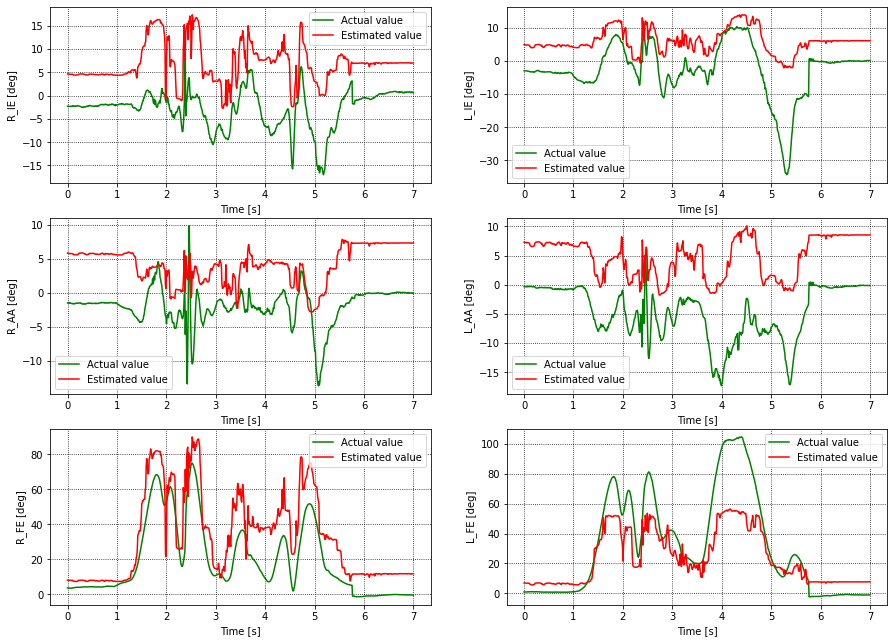

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math

# features
features=np.squeeze(np.array(features))
# lablels
labels=np.squeeze(np.array(labels))
# predictions
predictions=np.squeeze(np.array(predictions))

# Pandas DataFrame of the above datasets
pd_features=pd.DataFrame(features,columns=features_names)
pd_labels=pd.DataFrame(labels,columns=labels_names)
pd_predictions=pd.DataFrame(data=predictions,columns=labels_names)

#figsize=(8,8)
#fig=plt.figure(figsize=figsize)
#sns.lineplot(data=pd_labels,x=range(pd_labels.shape[0]),y='R_IE')


freq=100.0;
Time=np.linspace(0,labels.shape[0]/freq,num=labels.shape[0])


# Plots
figsize=(15,11)
fig=plt.figure(figsize=figsize)
axs=fig.subplots(3,2)

for plot_idx, label_name in enumerate(labels_names):
    axs[plot_idx%3,plot_idx//3].plot(Time,pd_labels[label_name],'g')
    axs[plot_idx%3,plot_idx//3].plot(Time,pd_predictions[label_name],'r')
    axs[plot_idx%3,plot_idx//3].legend(['Actual value','Estimated value'])
    axs[plot_idx%3,plot_idx//3].set_xlabel("Time [s]")
    axs[plot_idx%3,plot_idx//3].set_ylabel(label_name+" [deg]")
    axs[plot_idx%3,plot_idx//3].grid(which='both',axis='x',color='k',linestyle=':')
    axs[plot_idx%3,plot_idx//3].grid(which='both',axis='y',color='k',linestyle=':')
"""
axs[0,0].plot(Time,pd_labels['R_IE'],"g")
axs[0,0].plot(Time, pd_predictions['R_IE'],"r")
axs[0,0].legend(['Actual knee','Estimated knee'])
axs[0,0].set_xlabel("Time [s]")
axs[0,0].set_ylabel(u"$IE [\deg]$")

axs[1,0].plot(Time,pd_labels['R_AA'],"g")
axs[1,0].plot(Time,pd_predictions['R_AA'],"r")
axs[1,0].legend(['Actual knee','Estimated knee'])
axs[1,0].set_xlabel("Time [s]")
axs[1,0].set_ylabel(u"$AA [\deg]$")


axs[2,0].plot(Time, pd_labels['R_FE'],"g")
axs[2].plot(Time, pd_predictions['R_FE'],"r")
axs[2].legend(['Actual knee','Estimated knee'])
axs[2].set_xlabel("Time [s]")
axs[2].set_ylabel(u"$FE [\deg]$")


#ESM
R_IE_error=pd_predictions-pd_labels
RMSE = math.sqrt(np.square(np.subtract(pd_labels.values,pd_predictions.values)).mean()) 
print("RMSE: {}".format(RMSE))

print("Actual labels:\n",pd_labels.head())
print("Predictions:\n",pd_predictions.head())
print("Error:\n",R_IE_error.head())

"""

## LSTM V1.0 Model

In [ ]:

import torch.nn as nn
class MyLSTM_Model(nn.Module):
    def __init__(self,input_dim, hidden_dim, layer_dim,output_dim):
        super(MyLSTM_Model,self).__init__()
        self.input_dim=input_dim
        self.hidden_dim=hidden_dim
        self.layer_dim=layer_dim
        self.output_dim=output_dim
        
        self.bn1 = nn.Dropout()
        self.lstm=nn.LSTM(self.input_dim, self.hidden_dim, self.layer_dim, batch_first=True)
        self.fc=nn.Linear(hidden_dim,output_dim) #(16,6)
        
    def forward(self,x):# batch_size, sequence, input_size=features_dim
        # (layer_dim, batch_size, hidden_dim)
        h0=torch.zeros(self.layer_dim,x.size(0),self.hidden_dim).to(device)
        c0=torch.zeros(self.layer_dim,x.size(0),self.hidden_dim).to(device)
        out,(hn,cn)=self.lstm(x,(h0.detach(),c0.detach()))
        print("out shape:",out.shape)
        results=self.fc(out[:,-1,:])# batch size=10, sequence_dim (1),hidden_dim (16)
        return results
    

## LSTM V2.0 Model

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.2):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            dropout=dropout,
            bidirectional=False, )
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        batch_size = x.size()[0]
        seq_length = x.size()[1]

        x = x.view(seq_length, batch_size, -1)

        # We need to pass the initial cell states
        h0 = Variable(torch.zeros(seq_length, batch_size, self.hidden_size))
        c0 = Variable(torch.zeros(seq_length, batch_size, self.hidden_size))
        outputs, (ht, ct) = self.rnn(x, (h0, c0))

        out = outputs[-1]  # We are only interested in the final prediction
        out = self.bn1(self.fc1(out))
        out = self.relu(out)
        out = F.dropout(out, training=self.training)
        out = self.fc2(out)
        return out

## LSTM v3

In [ ]:
import torch.nn as nn
"""
The class nn model based on LSTM
"""
class MyLstmV3(nn.Module):
  def __init__(self, num_features,num_labels, num_sequences):
    super(MyLstmV3,self).__init__()
    self.model=nn.Sequential(nn.LSTM(input_size=num_features, hidden_size=100,num_layers=2,dropout=0.2,bidirectional=False),
                             nn.Linear(100,num_labels)
                             )
    
  def forward(self,x):
    out=self.model(x)
    return out

## Training LSTM v3

In [ ]:
datasets=DroplandingDataset(h5format_dataset,features_names,labels_names)
train_sets, test_sets, val_sets=torch.utils.data.random_split(datasets,[60000,10000,26983])
  # 创建数据集的可迭代对象，并且分批、打乱数据集
train_loader = torch.utils.data.DataLoader(dataset=train_sets, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_sets, batch_size=batch_size, shuffle=True)
  #print("train_loader:", next(iter(train_loader)).shape)
model=MyLstmV3(num_features,num_labels,num_sequences=2)

def train(model,train_loader,test_loader):

  if torch.cuda.is_available():
      model = model.cuda()
  criterion=nn.MSELoss()
  optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)
  #optimizer=torch.optim.SGD(model.parameters(),lr=learning_rate)

  iter=0
  loss_list = [] # 保存loss
  accuracy_list = [] # 保存accuracy
  iteration_list = [] # 保存循环次数
  outputs_list=[]

  plt.ion()
  for epoch in range(epochs):
      for i, (features, labels) in enumerate(train_loader):
          model.train() # 声明训练
          features=features.to(device)
          labels = labels.to(device)
          # 梯度清零（否则会不断累加）
          optimizer.zero_grad()
          # 前向传播
          #print(" features shape:{}, labels shape:{} ".format(features.shape, labels.shape))
          outputs = model(features)
          #print("outputs shape:{}, labels shape:{} ".format(outputs.shape, labels.shape))
          # 计算损失
          loss = criterion(outputs, labels)
          # 反向传播
          loss.backward()
          # 更新参数
          optimizer.step()
          # 计数器自动加1
          iter+=1
          iter_step=1000
          lossplot_x_axis=range(len(train_loader)*epochs//iter_step)
          if(iter%iter_step==0):
              #plt.gca().cla()
              loss_list.append(loss.cpu().detach().numpy())
              iteration_list.append(iter)
              print("epoch: {}, loss: {}".format(epoch,loss.cpu().detach()))
              #Visualization of trainning
              #plt.cla()
              # 无误差真值曲线
              #plt.scatter(features.cpu().numpy()[-1,1], labels.cpu().numpy()[-1,1], c='blue', lw='3')
              # 有误差散点
              #plt.scatter(x_data.numpy(), y_data.numpy(), c='orange')
              # 实时预测的曲线
              #plt.plot(iter,loss_list[-1], 'ro', lw='2')
              #plt.text(-0.5, -65, 'Time=%d Loss=%.4f' % (i, loss.cpu().data.numpy()), fontdict={'size': 15, 'color': 'red'})
              #plt.pause(0.1)
              if(loss_list[-1]<0.06):
                save_model_parameters(based_path_folder,model,loss_list,iter)
                return 0

  save_model_parameters(based_path_folder,model,loss_list,iter)

train(model,train_loader,test_loader)



RuntimeError: ignored

## Training: LSTM model 

In [ ]:
import torchvision.transforms as transforms
import pdb
# Declare super parameters
output_dim=1 # two legs's knee angles, right: interal rotation, abduction, flexion as well as left size: ...
input_dim=8
layer_dim=2
hidden_dim=8
batch_size=20
epochs=5
num_sequences=2
dim_sequences=1
learning_rate=0.01


#model=MyLSTM_Model(input_dim,hidden_dim,layer_dim,output_dim)
model=MyFNN_Model(input_dim)
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

iter=0

loss_list = [] # 保存loss
accuracy_list = [] # 保存accuracy
iteration_list = [] # 保存循环次数

for epoch in range(epochs):
    for i, (features, labels) in enumerate(train_loader):
        model.train() # 声明训练
        # 一个batch的数据转换为RNN的输入维度
        #features = features.view(-1, sequence_dim, input_dim).requires_grad_().to(device) 
        features=features.to(device)
        labels = labels.to(device)
        # 梯度清零（否则会不断累加）
        optimizer.zero_grad()
        # 前向传播
        #print(" features shape:{}, labels shape:{} ".format(features.shape, labels.shape))
        outputs = model(features)
        #print("outputs shape:{}, labels shape:{} ".format(outputs.shape, labels.shape))
        # 计算损失
        loss = criterion(outputs, labels)
        # 反向传播
        loss.backward()
        # 更新参数
        optimizer.step()
        # 计数器自动加1
        iter += 1
        # 模型验证
        if iter % 500 == 0:
            model.eval() # 声明
            # 计算验证的accuracy
            correct = 0.0
            total = 0.0
            # 迭代测试集，获取数据、预测
            for features,labels in test_loader:
                features = features.to(device) 
                # 模型预测
                outputs = model(features)
                # 获取预测概率最大值的下标
                #predict = torch.max(outputs.data, 1)[1]
                # 统计测试集的大小
                #total += labels.size(0)
                # 统计判断/预测正确的数量
                if torch.cuda.is_available():
                    correct += (outputs.gpu() == labels.gpu()).sum()
                else:
                    correct += (outputs == labels).sum()
            # 计算
            accuracy = correct / total * 100
            # 保存accuracy, loss, iteration
            loss_list.append(loss.data)
            accuracy_list.append(accuracy)
            iteration_list.append(iter)
            # 打印信息
            print("loop : {}, Loss : {}, Accuracy : {}".format(iter, loss.item(), accuracy))
    

RuntimeError: ignored